Version Notes:

Base assets don't improve predictability??? (ie. can't match R-squareds and test-stats/pvalues)

Bootstrap correct???

# Creation of GDP and CPI Mimicking portfolios

## Data Prep

In [197]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [198]:
data = pd.read_csv('merged_data.csv', index_col=0)

In [199]:
data['def'] = np.log(data['corp_bond_return']/data['corp_bond_return'].shift(1)) - data['20y_return']
data['term'] = data['30y_return'] - data['rf']

In [200]:
data['defy'] = (data['BAA'] - data['AAA'])/100
data['termy'] = (data['10 year'] - data['1 year'])/100

In [227]:
# Predictors
predictors = data[['SL', 'SM', 'SH', 'BL', 'HM', 'BH',
                                   'def', 'term', 'defy', 'termy', 'rf']].copy().dropna()
portfolios = ['SL', 'SM', 'SH', 'BL', 'HM', 'BH']
for portfolio in portfolios:
    predictors[portfolio] = predictors[portfolio]/100 - predictors['rf'] 

In [228]:
predictors.head()

,SL,SM,SH,BL,HM,BH,def,term,defy,termy,rf
1973-04-30,-0.116366,-0.059144,-0.054957,-0.065703,-0.030393,-0.018819,-0.003262,-0.001740,0.0083,-0.0010,0.005002
1973-05-31,-0.111271,-0.077172,-0.078682,-0.013939,-0.025844,-0.038340,0.008574,-0.013672,0.0077,-0.0023,0.005098
1973-06-30,-0.056169,-0.034510,-0.032328,-0.014313,-0.008784,-0.014188,0.000121,-0.007495,0.0076,-0.0080,0.005379
1973-07-31,0.176029,0.095916,0.084404,0.057668,0.016414,0.043144,0.041822,-0.048362,0.0079,-0.0144,0.006540
1973-08-31,-0.045824,-0.059812,-0.047233,-0.039251,-0.036736,-0.013048,-0.032932,0.026077,0.0085,-0.0122,0.006855


In [229]:
# GDP & CPI
gdp = data['BBKMGDP'].rename('gdp').to_frame().iloc[:-3]
cpi = data['CPIAUCSL'].rename('cpi').to_frame().iloc[:-3]

# Transformations 
gdp['gdp_mom'] = gdp['gdp'] / 100
gdp['level'] = (1 + gdp['gdp_mom']).cumprod()
gdp['gdp_yoy'] = np.log(gdp['level'] / gdp['level'].shift(12)) # 4 quarter change = 12 month change

cpi['cpi_mom'] = np.log(cpi['cpi'] / cpi['cpi'].shift(1))
cpi['cpi_yoy'] = np.log(cpi['cpi'] / cpi['cpi'].shift(12))

cpi = cpi.shift(1)

In [230]:
# Data up to pre-COVID
predictors = predictors.loc[:'2020']
gdp = gdp.loc[:'2020']
cpi = cpi.loc[:'2020']

## Can the base assets predict future GDP & CPI?
Since this is an expectation of monthly GDP, instead of "news related to future GDP growth", this factor would be more related to innovations in expectations of future GDP growth. 

In [231]:
# Data
controls = sm.add_constant(predictors.iloc[:,-3:].shift(2).dropna())
constant = controls.iloc[:,0]
assets = predictors.iloc[1:,0:8].shift(1).dropna()
y = gdp['gdp_yoy'].loc['1973-04':].iloc[2:]

### GDP Control Model

In [241]:
control_model = sm.OLS(y,controls).fit(cov_type='HAC', cov_kwds={'maxlags':3})
coeffs_0 = [x + '=0' for x in controls.iloc[:,1:]]
print(control_model.wald_test(','.join(coeffs_0), scalar=True, use_f=False))
# control_model.summary()

<Wald test (chi2): statistic=85.81041441519343, p-value=1.7385643906897478e-18, df_denom=3>


### GDP Bootstrap
Vassalou (2003) use a bootstrap procedure to see if the base assets are jointly significant in predicted GDP above and beyond the control variables.

Specifically the bootstrap procedure is as follows:

1) The regression is estimated: 

<font size=3>
$
\%\Delta GDP_{t,t+12} = a + cB_{t-1,t} + kZ_{t-2,t-1} + e_{t,t+12}
$
</font>

Where B is a vector of returns on the 8 base assets, and Z is a vector of control variables. The Wald Statistic and p-value is stored.

2) Draw a random sample (with replacement) of the explanatory variables and estimated residuals

3) Compute a GDP growth rate forcast assuming c=0

<font size=3>
$
\%\Delta \hat{GDP}_{t,t+12} = \hat{a} + \hat{k}Z_{t-2,t-1} + \hat{e}_{t,t+12}
$
</font>

4) Regress the null GDP growth rate from (3) on the bootstrapped sample of explanatory variables; compute the Wald Statistic

6) This is repeated 10,000 times. The actual Wald Statistic is compared against the bootstrapped distribution, and the emprical p-value is computed. 

#### Only base assets

In [274]:
# Initial Model
model1 = sm.OLS(y, pd.concat([constant, assets], axis=1)).fit(cov_type='HAC', cov_kwds={'maxlags':3})

coeffs1_0 = [x + '=0' for x in assets]
wald_stat1 = model1.wald_test(','.join(coeffs1_0), scalar=True, use_f=False).statistic
p1 = model1.wald_test(','.join(coeffs1_0), scalar=True, use_f=False).pvalue
print('P-value=', f'{p1:0.5f}', 'Wald Stat= ', f'{wald_stat1:0.3f}')

P-value= 0.65455 Wald Stat=  5.935


In [275]:
# model1.summary()

In [276]:
sample_df1 = pd.concat([y, constant, assets], axis=1)
n = len(sample_df1)

In [277]:
# Bootstrap
boot1_wald = []
n_boots = 10000

for _ in range(n_boots):
    boot_df = sample_df1.sample(n=n, replace=True)
    
    boot_model = sm.OLS(boot_df['gdp_yoy'], boot_df.iloc[:,1:]).fit(cov_type='HAC', cov_kwds={'maxlags':3})
    
    coeffs_0 = [x + '=0' for x in boot_df.iloc[:,-8:]]
    boot1_wald.append(boot_model.wald_test(','.join(coeffs_0), scalar=True, use_f=False).statistic)

boot1_wald = np.array(boot1_wald)

In [278]:
empirical_p1 = np.sum(boot1_wald >= wald_stat1)/len(boot1_wald)
print(f'{empirical_p1: 0.5f}')

 0.94510


#### Base assets + Controls

In [279]:
# Initial Model
model2 = sm.OLS(y, pd.concat([controls, assets], axis=1)).fit(cov_type='HAC', cov_kwds={'maxlags':3})

coeffs2_0 = [x + '=0' for x in assets]
wald_stat2 = model2.wald_test(','.join(coeffs2_0), scalar=True, use_f=False).statistic
p2 = model2.wald_test(','.join(coeffs2_0), scalar=True, use_f=False).pvalue
print('P-value=', f'{p2:0.5f}', 'Wald Stat= ', f'{wald_stat2:0.3f}')

P-value= 0.24498 Wald Stat=  10.294


In [280]:
# model2.summary()

In [281]:
sample_df2 = pd.concat([y, controls, assets], axis=1)
n = len(sample_df2)

In [282]:
# Bootstrap
boot2_wald = []
n_boots = 10000

for _ in range(n_boots):
    boot_df = sample_df2.sample(n=n, replace=True)
    
    boot_model = sm.OLS(boot_df['gdp_yoy'], boot_df.iloc[:,1:]).fit(cov_type='HAC', cov_kwds={'maxlags':3})
    
    coeffs_0 = [x + '=0' for x in boot_df.iloc[:,-8:]]
    boot2_wald.append(boot_model.wald_test(','.join(coeffs_0), scalar=True, use_f=False).statistic)

boot2_wald = np.array(boot2_wald)

In [283]:
empirical_p2 = np.sum(boot2_wald >= wald_stat2)/len(boot2_wald)
print(f'{empirical_p2: 0.5f}')

 0.88770


### CPI

In [258]:
y_cpi = cpi['cpi_yoy'].loc['1973-04':].iloc[2:]

In [284]:
# Initial Model
cpi_model = sm.OLS(y_cpi, pd.concat([controls, assets], axis=1)).fit(cov_type='HAC', cov_kwds={'maxlags':3})

# Wald Test for controls vs mean
cpi_coeffs_0 = [x + '=0' for x in pd.concat([controls.iloc[:,1:], assets], axis=1)]
wald_stat_cpi = cpi_model.wald_test(','.join(cpi_coeffs_0), scalar=True, use_f=False).statistic
p_cpi = cpi_model.wald_test(','.join(cpi_coeffs_0), scalar=True, use_f=False).pvalue
print('P-value=', f'{p_cpi:0.5f}', 'Wald Stat= ', f'{wald_stat_cpi:0.3f}')

# Wald Test for base assets vs mean + controls
cpi_coeffs_0 = [x + '=0' for x in assets]
wald_stat_cpi = cpi_model.wald_test(','.join(cpi_coeffs_0), scalar=True, use_f=False).statistic
p_cpi = cpi_model.wald_test(','.join(cpi_coeffs_0), scalar=True, use_f=False).pvalue
print('P-value=', f'{p_cpi:0.5f}', 'Wald Stat= ', f'{wald_stat_cpi:0.3f}')

P-value= 0.00000 Wald Stat=  218.190
P-value= 0.00143 Wald Stat=  25.216


Base assets do appear to have predictive power (asymptotically)

#### CPI Bootstrap

In [285]:
sample_df_cpi = pd.concat([y_cpi, controls, assets], axis=1)
n = len(sample_df_cpi)

In [287]:
boot_cpi_wald = []
n_boots = 10000

for _ in range(n_boots):
    boot_df = sample_df_cpi.sample(n=n, replace=True)
    
    boot_model = sm.OLS(boot_df['cpi_yoy'], boot_df.iloc[:,1:]).fit(cov_type='HAC', cov_kwds={'maxlags':3})
    
    coeffs_0 = [x + '=0' for x in boot_df.iloc[:,-8:]]
    boot_cpi_wald.append(boot_model.wald_test(','.join(coeffs_0), scalar=True, use_f=False).statistic)

boot_cpi_wald = np.array(boot_cpi_wald)

In [288]:
empirical_p_cpi = np.sum(boot_cpi_wald >= wald_stat_cpi)/len(boot_cpi_wald)
print(f'{empirical_p_cpi: 0.5f}')

 0.89290


<AxesSubplot:ylabel='Frequency'>

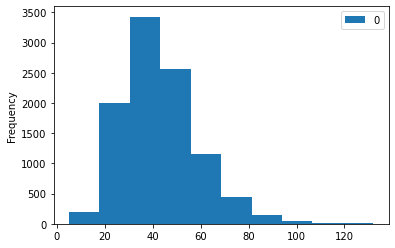

In [291]:
pd.DataFrame(boot_cpi_wald).plot.hist()

### Systems Estimation

In [186]:
from linearmodels.system.model import SUR

In [164]:
# GDP and CPI Stacked
y = pd.merge(cpi['cpi_yoy'], gdp['gdp_yoy'], left_index=True, right_index=True).loc['1973-04':].iloc[1:]
X = sm.add_constant(predictors.iloc[:,-3:].shift(1).dropna())

In [181]:
model = SUR.multivariate_ls(y, X).fit(cov_type='kernel', kernel='bartlett',bandwidth=3)

In [182]:
print(model)

                           System OLS Estimation Summary                           
Estimator:                        OLS   Overall R-squared:                   0.2818
No. Equations.:                     2   McElroy's R-squared:                 0.4092
No. Observations:                 596   Judge's (OLS) R-squared:             0.2818
Date:                Tue, Mar 14 2023   Berndt's R-squared:                  0.6385
Time:                        20:18:30   Dhrymes's R-squared:                 0.2818
                                        Cov. Estimator:                      kernel
                                        Num. Constraints:                      None
                Equation: cpi_yoy, Dependent Variable: cpi_yoy                
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.0216     0.0055     3.9126     0.0001      0.0108      0.0325
defy        

## Factor Creation